# Heart Disease Analysis

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from scipy.stats import entropy

# load the dataset
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Functions

In [19]:
def run_all_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    models = {
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(random_state=42),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    return pd.DataFrame(model_performance)

def automate_pca(pca_components, X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
  pca = PCA(n_components=pca_components)
  X_train_pca = pca.fit_transform(X_train_scaled)
  X_test_pca = pca.transform(X_test_scaled)
  
  models = run_all_models(X_train_pca, X_test_pca, y_train_encoded, y_test_encoded)
  print(models)
  
def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): _description_

  Returns:
      pd.DataFrame: _description_
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

# EDA Analysis

In [12]:
df = pd.read_csv("heart.csv")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [7]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [8]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [10]:
entropy_df = calculate_entropy(df)
entropy_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
entropy,5.225599,0.741941,1.631436,4.698175,6.750721,0.783403,1.368659,6.344942,0.973321,3.702449,1.288266,0.991764


In [9]:
print(df.shape)
target = df.values[:,-1]
counter = Counter(target)

for k, v in counter.items():
  per = v/ len(target) * 100
  print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(918, 12)
Class=0, Count=410, Percentage=44.662%
Class=1, Count=508, Percentage=55.338%


## Fairly Balanced Dataset

# Data Preperation

In [13]:
df["Sex"] = df["Sex"].apply(lambda x: 1 if x =="M" else 0)
df["ExerciseAngina"] = df["ExerciseAngina"].apply(lambda x: 1 if x == "Y" else 0)
df["ST_Slope"] = df["ST_Slope"].apply(lambda x: 0 if x =="Flat" else 1 if x == "Up" else 2)
df["RestingECG"] = df["RestingECG"].apply(lambda x: 0 if x =="Normal" else 1 if x == "LVH" else 2)
df["ChestPainType"] = df["ChestPainType"].apply(lambda x: 0 if x =="ASY" else 1 if x == "NAP" else 2 if x == "ATA" else 3)

# Visuals

<Axes: >

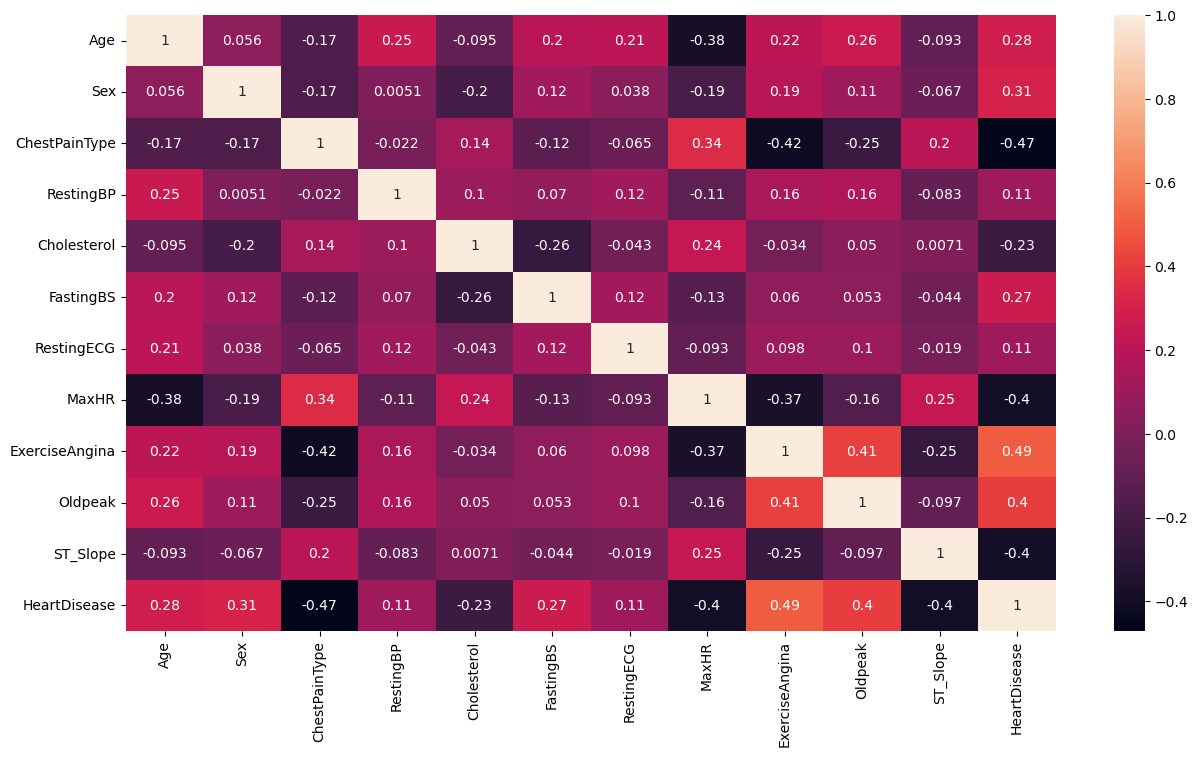

In [15]:
plt.figure(figsize=(15,8))
relations = df.corr()
sns.heatmap(data=relations, annot=True)

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/1449648563.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/1449648563.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/1449648563.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/1449648563.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/1449648563.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/1449648563.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/14496

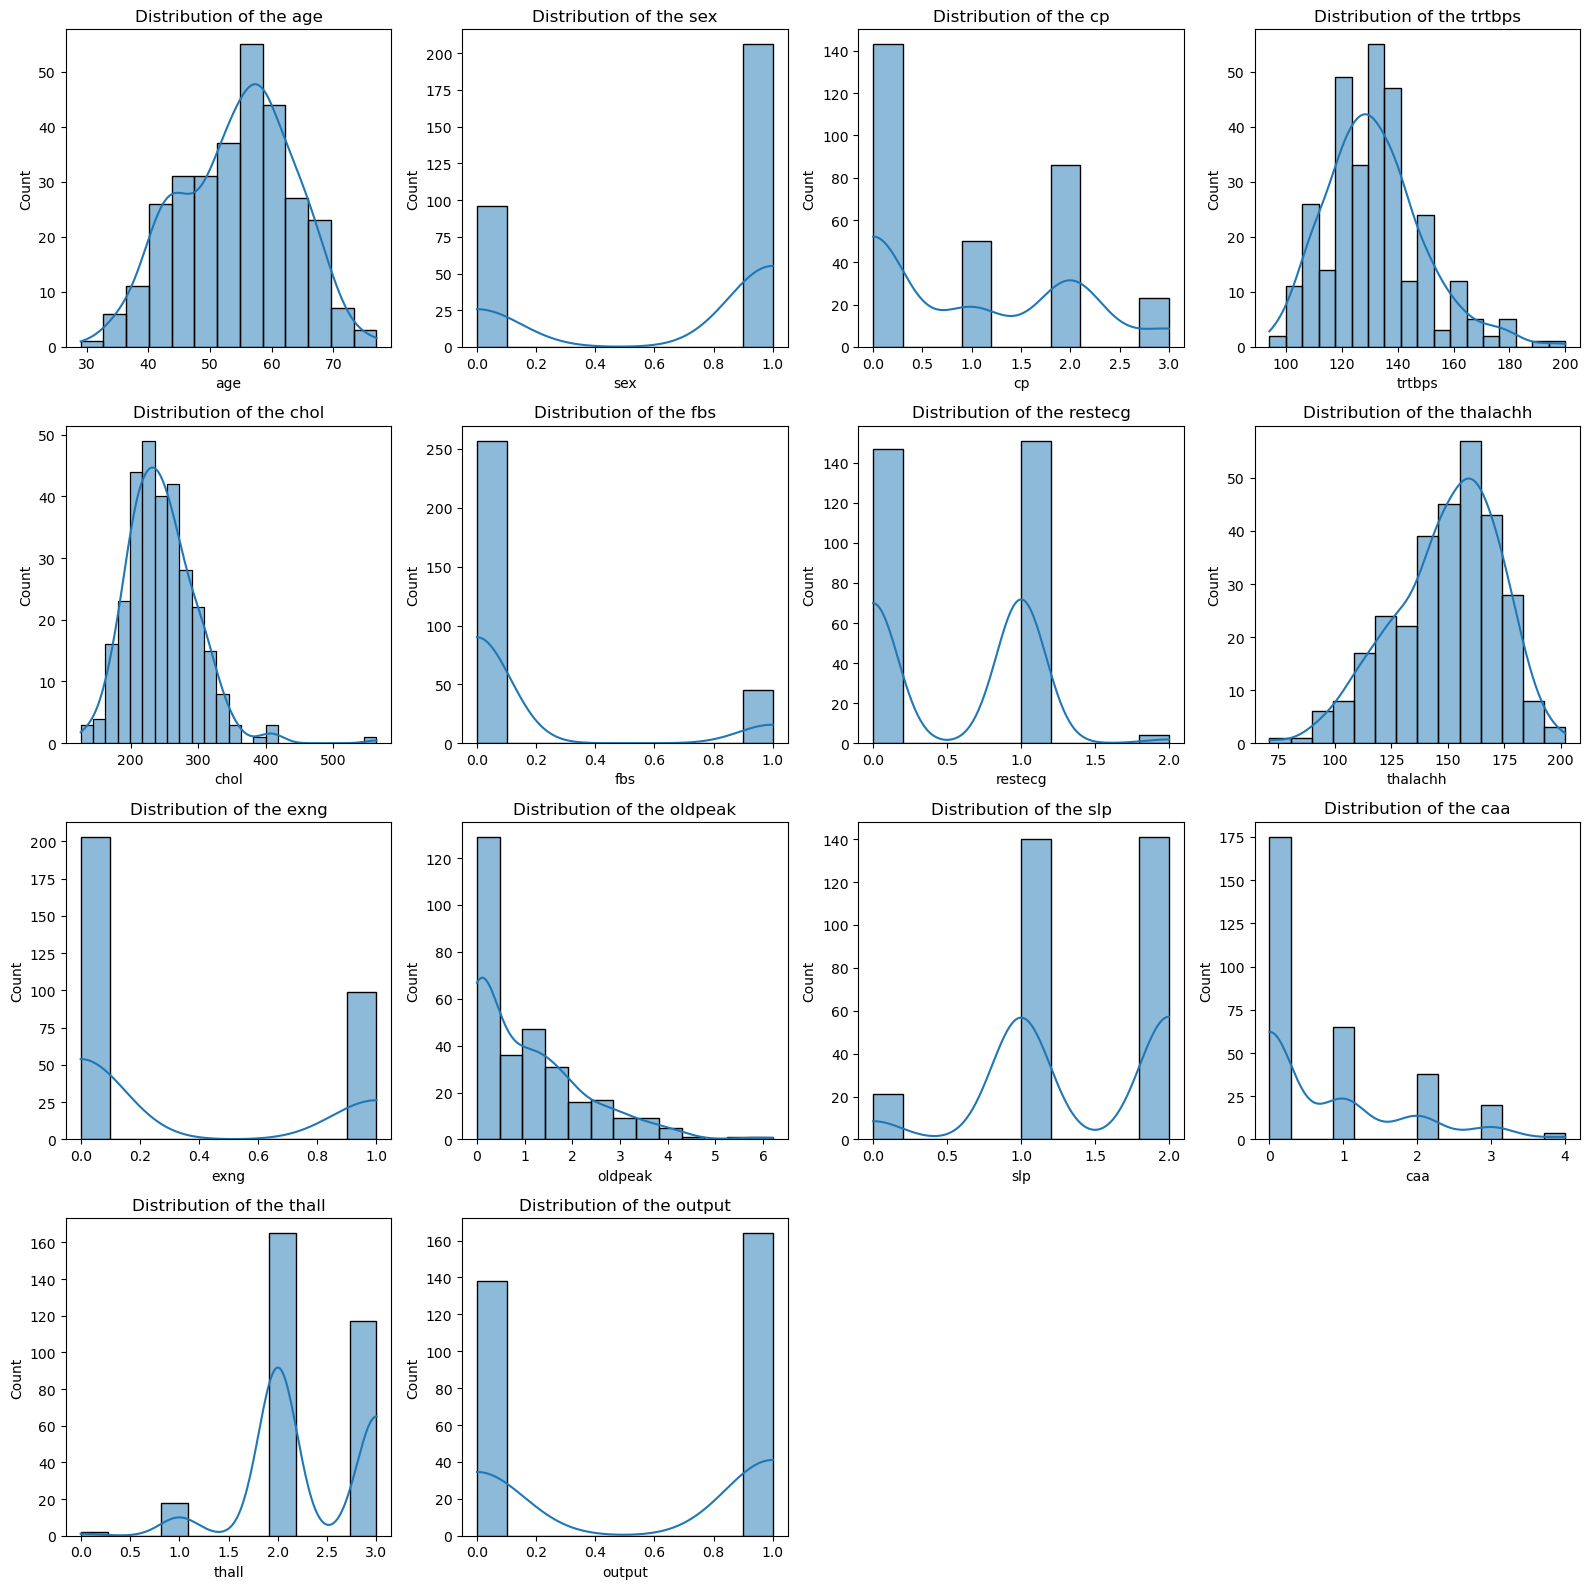

In [14]:
plt.figure(figsize=(16,16))
col_values = len(df.columns)
rows = (col_values +3)//4

for idx, col in enumerate(df.columns):
  plt.subplot(rows,4,idx+1)
  sns.histplot(df[col], kde=True,)
  plt.title(f"Distribution of the {col}")
  plt.tight_layout()
  plt.plot()

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/844493827.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/844493827.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/844493827.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/844493827.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/844493827.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/844493827.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_61203/844493827.p

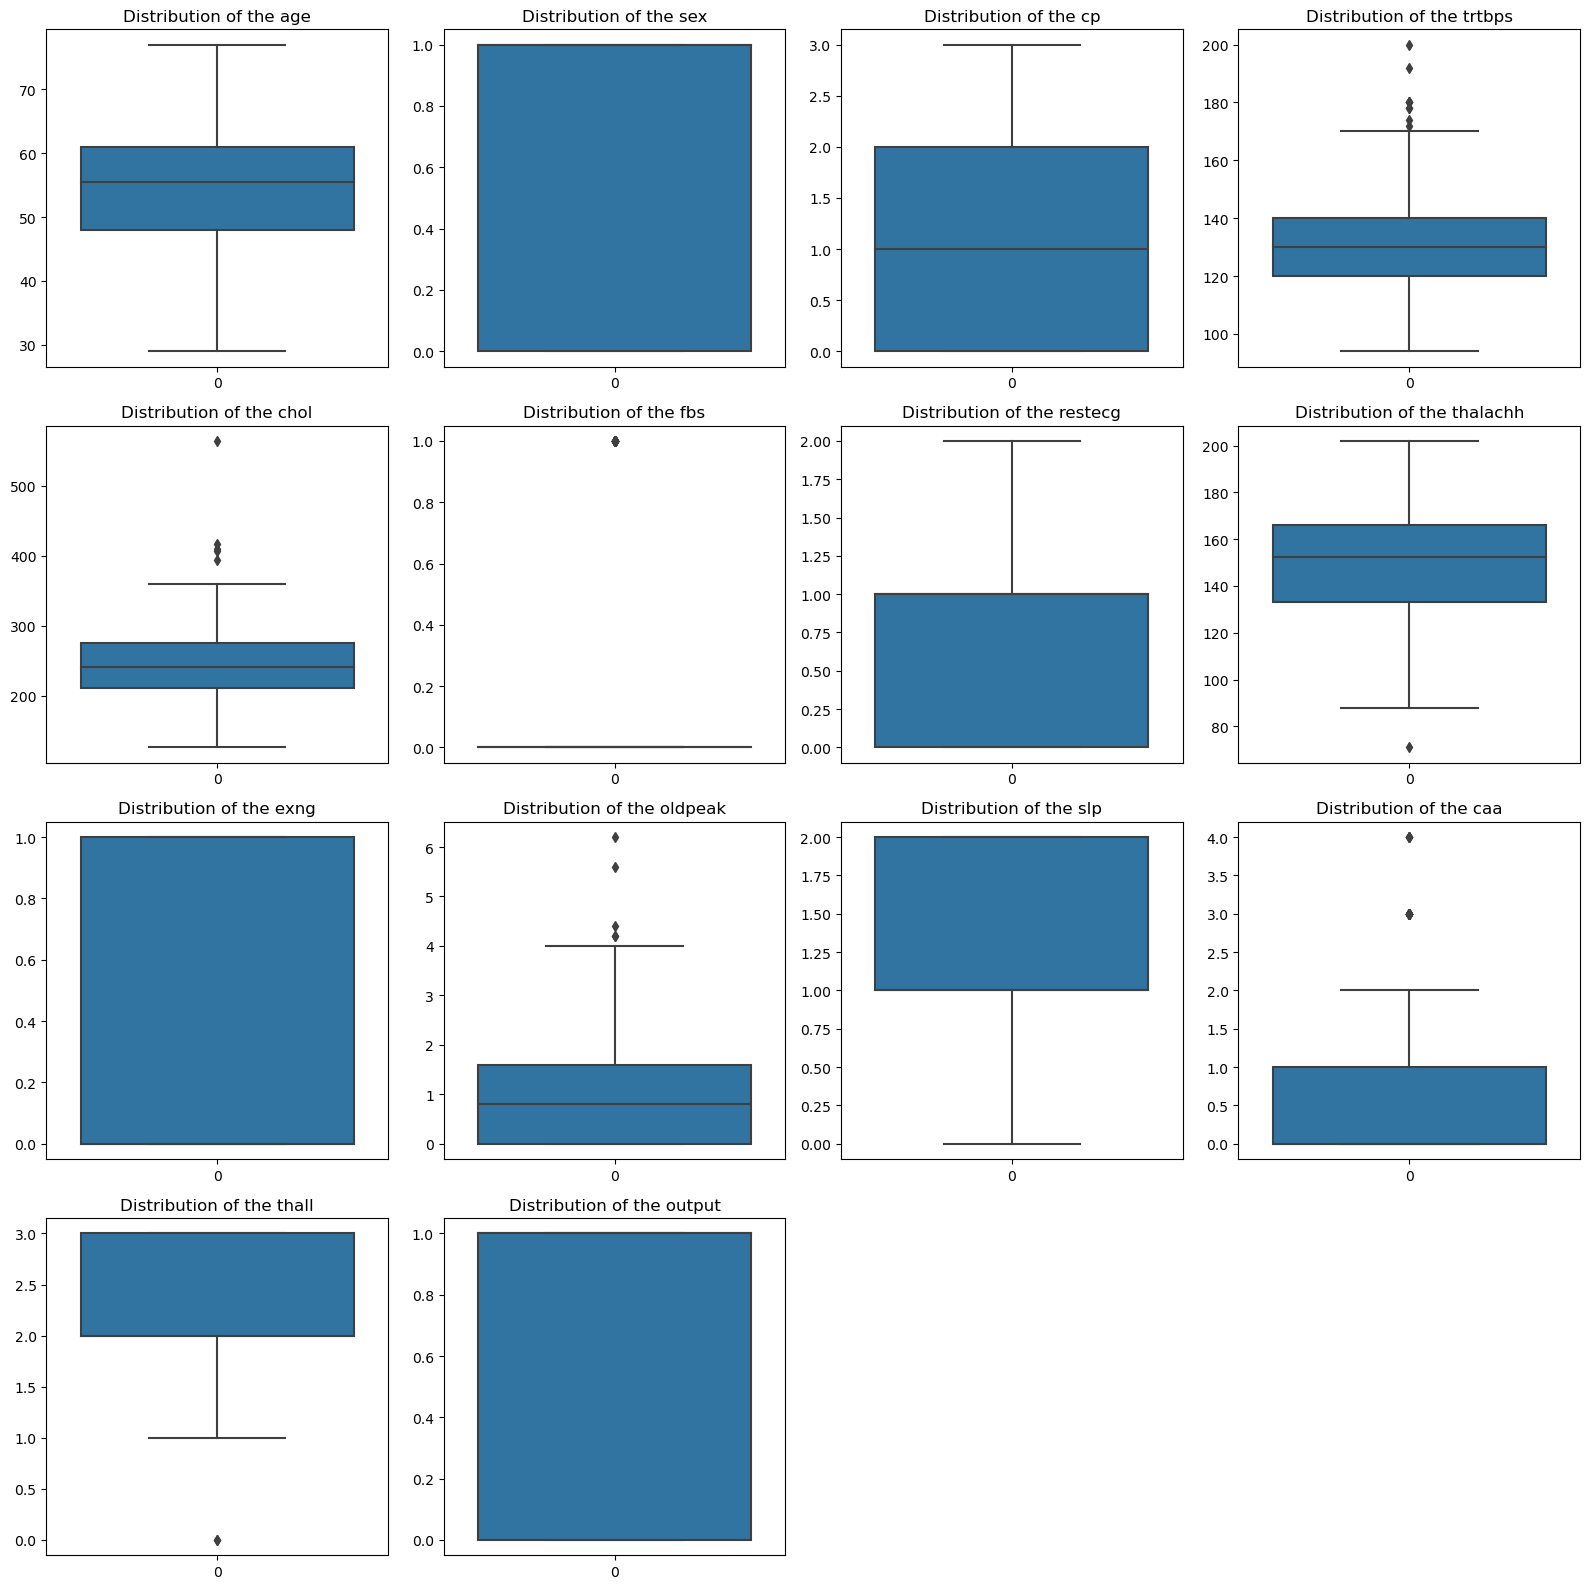

In [16]:
plt.figure(figsize=(16,16))
col_values = len(df.columns)
rows = (col_values +3)//4

for idx, col in enumerate(df.columns):
  plt.subplot(rows,4,idx+1)
  sns.boxplot(df[col])
  plt.title(f"Distribution of the {col}")
  plt.tight_layout()
  plt.plot()

## We have some outliers in the dataset, we will explore how to deal with these outliers by either removing them or re-shaping the distribution

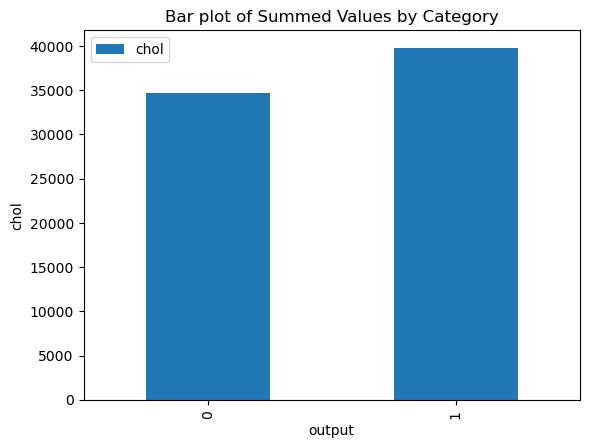

In [19]:
grouped_df = df.groupby("output")["chol"].sum().reset_index()

grouped_df.plot(kind="bar", x="output", y="chol", legend =True)
plt.xlabel("output")
plt.ylabel("chol")
plt.title("Bar plot of Summed Values by Category")
plt.show()

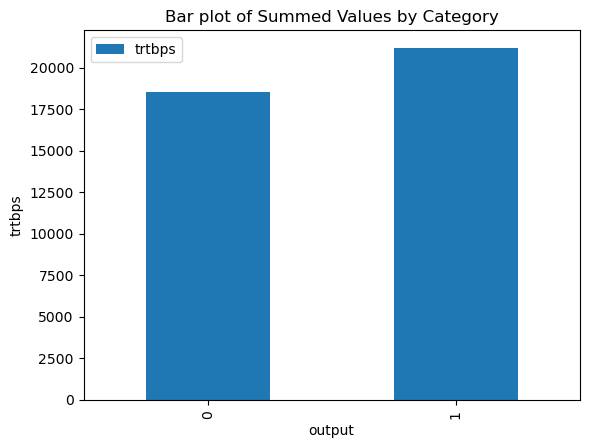

In [20]:
grouped_df = df.groupby("output")["trtbps"].sum().reset_index()

grouped_df.plot(kind="bar", x="output", y="trtbps", legend =True)
plt.xlabel("output")
plt.ylabel("trtbps")
plt.title("Bar plot of Summed Values by Category")
plt.show()

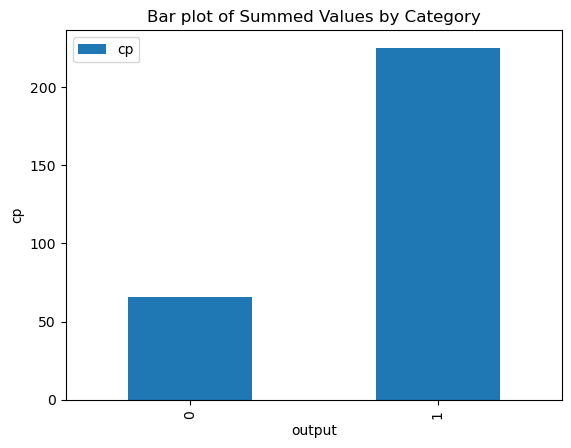

In [22]:
grouped_df = df.groupby("output")["cp"].sum().reset_index()

grouped_df.plot(kind="bar", x="output", y="cp", legend =True)
plt.xlabel("output")
plt.ylabel("cp")
plt.title("Bar plot of Summed Values by Category")
plt.show()

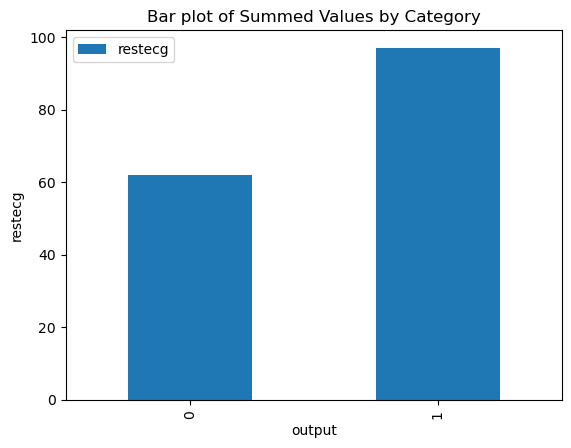

In [24]:
grouped_df = df.groupby("output")["restecg"].sum().reset_index()

grouped_df.plot(kind="bar", x="output", y="restecg", legend =True)
plt.xlabel("output")
plt.ylabel("restecg")
plt.title("Bar plot of Summed Values by Category")
plt.show()

### A relationship between chest pain and the target variable as well as rest ecg is identified. If we wanted to lower the dimesionality of the dataset, I believe these are columns that we would keep.

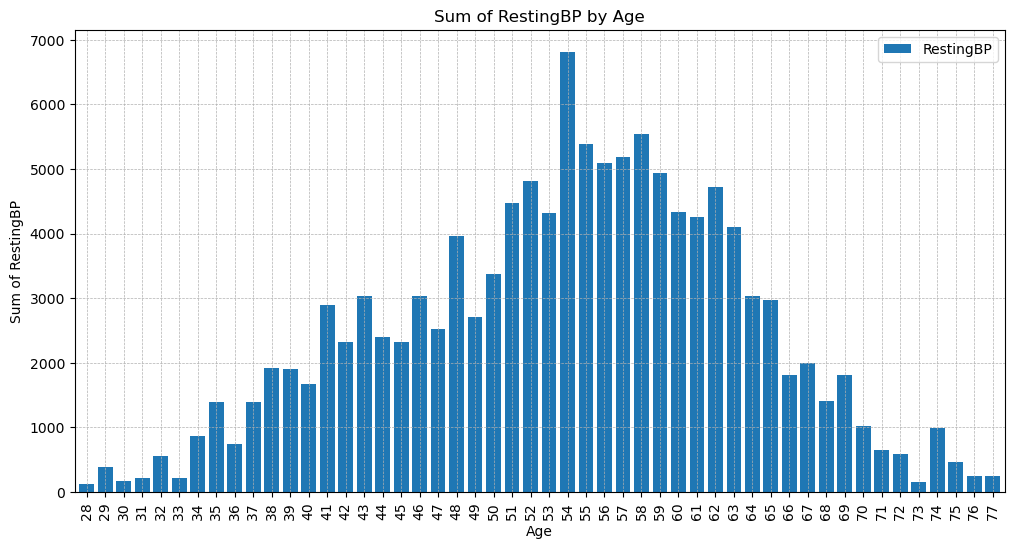

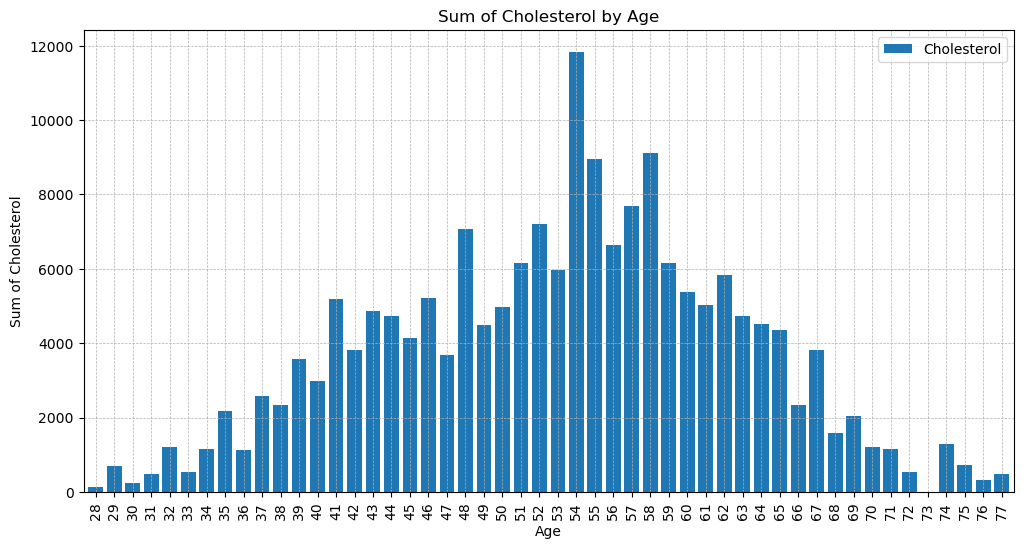

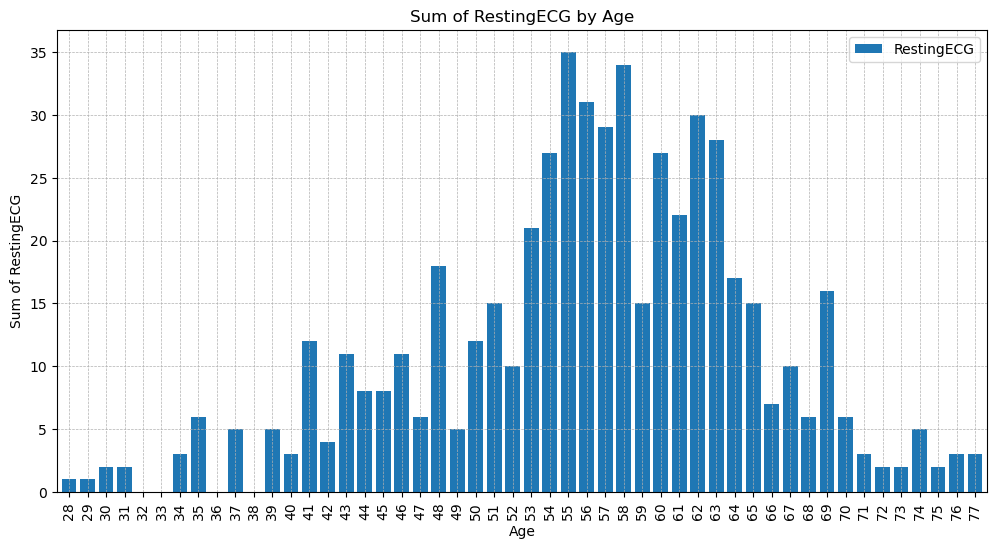

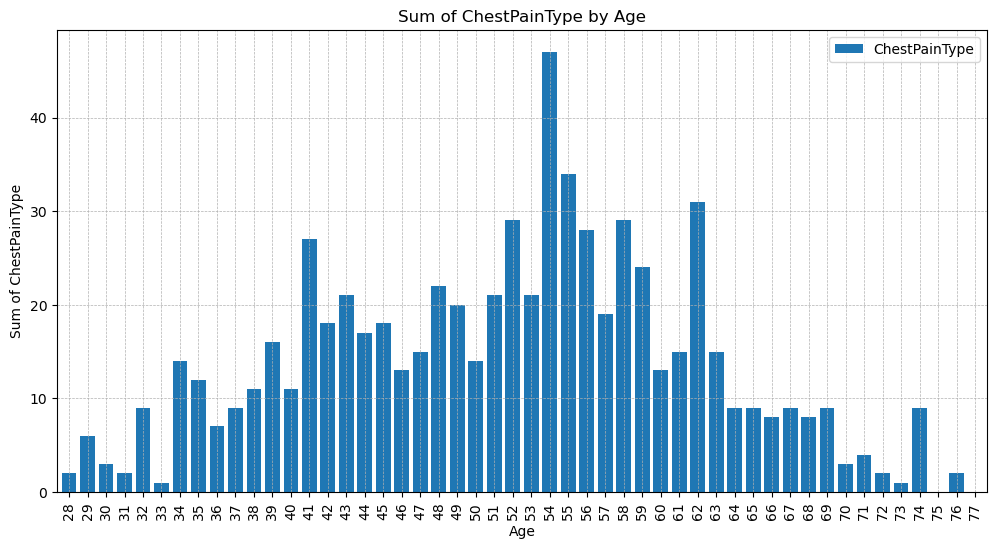

In [16]:
# Set a larger figure size and higher resolution
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

interested_columns = ["RestingBP", "Cholesterol", "RestingECG", "ChestPainType"]

for col in interested_columns:
    df_grouped = df.groupby("Age")[col].sum().reset_index()
    
    # Create the plot
    df_grouped.plot(kind="bar", x="Age", y=col, width=0.8) # Adjust bar width as needed
    
    # Set labels and title
    plt.xlabel("Age")
    plt.ylabel(f"Sum of {col}")
    plt.title(f"Sum of {col} by Age")
    
    # Add gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()

# Model Evaluation

In [17]:
from sklearn.metrics import fbeta_score
def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='stratified')
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean F2: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

(918, 11) (918,) Counter({1: 508, 0: 410})
Mean F2: 0.540 (0.070)


# Baseline Model Evaluation

### Baseline Model Performance tell us we need an F2 score of atleast 0.55%. One thing to note here, the F2 score metric minmizes false negatives. In this case, that would be telling a patient they don't have heart disease when in fact they do have heart disease. This is the scope through which I am guiding my analysis. Given that Heart Disease is one of the leading causes of death for adults in America, telling a patient incorrectly that they dont have heart disease when they do is an unacceptable and costly error.

In [20]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
models = run_all_models(X_train_scaled, X_test_scaled, y_train, y_test)
models.sort_values(by="Accuracy", ascending=False)

2024-04-07 17:30:38.752216: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6/6 [==============================] - 0s 587us/step - loss: 0.3327 - accuracy: 0.8859


,Model,Accuracy
4,XGBoost,0.885870
10,Sequential,0.885870
3,RandomForestClassifier,0.869565
5,GradientBoostingClassifier,0.864130
6,KNeighborsClassifier,0.864130
1,SVC,0.858696
9,GPC,0.858696
8,LDA,0.847826
0,LogisticRegression,0.842391
7,GaussianNB,0.836957


# Some great results right off the bat but let us focus our scoring metric on F2 instead of accuracy

# Advanced Model Metrics

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  f2 = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=f2, cv=cv, n_jobs=-1)
  return scores

# define models to test
def get_models():
  models, names = list(), list()
  # LDA
  models.append(LinearDiscriminantAnalysis()) 
  names.append('LDA')
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # XGB
  models.append(XGBClassifier())
  names.append('XGB')
  # KNN
  models.append(KNeighborsClassifier())
  names.append('KNN')
  # SVC
  models.append(SVC())
  names.append('SVC')
  # LR
  models.append(LogisticRegression())
  names.append('LR')
  # GPC
  models.append(GaussianProcessClassifier())
  names.append('GPC')
  # GNB
  models.append(GaussianNB())
  names.append('GNB')
  
  return models, names

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
  # Wrap the model in a pipeline with StandardScaler
  pipeline = Pipeline(steps=[('scaler', MinMaxScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
  # Evaluate the model
  scores = evaluate_model(X, y, pipeline)  # Replace X, y with your data
  results.append(scores)
  # summarize and store
  print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LDA 0.869 (0.043)
>RFC 0.897 (0.037)
>GBC 0.892 (0.039)
>XGB 0.890 (0.033)
>KNN 0.882 (0.036)
>SVC 0.907 (0.036)
>LR 0.871 (0.042)
>GPC 0.869 (0.040)
>GNB 0.879 (0.032)


# Advanced Analysis Results: XGB, GBC, RFC, SVC, KNN and GNB are some of the models we can further test on.

# Feature Analysis

## Since we have a mix of numeric and categorical inputs into a binary categorical output such as heart-disease vs no heart disease. This is a job suitable for either the ANOVA or mutual information measure given the dataset contains negative values and chi is not acceptable. I will try all of them and see what did the best. We could also use XGBC to test for feature importance which I will do below.

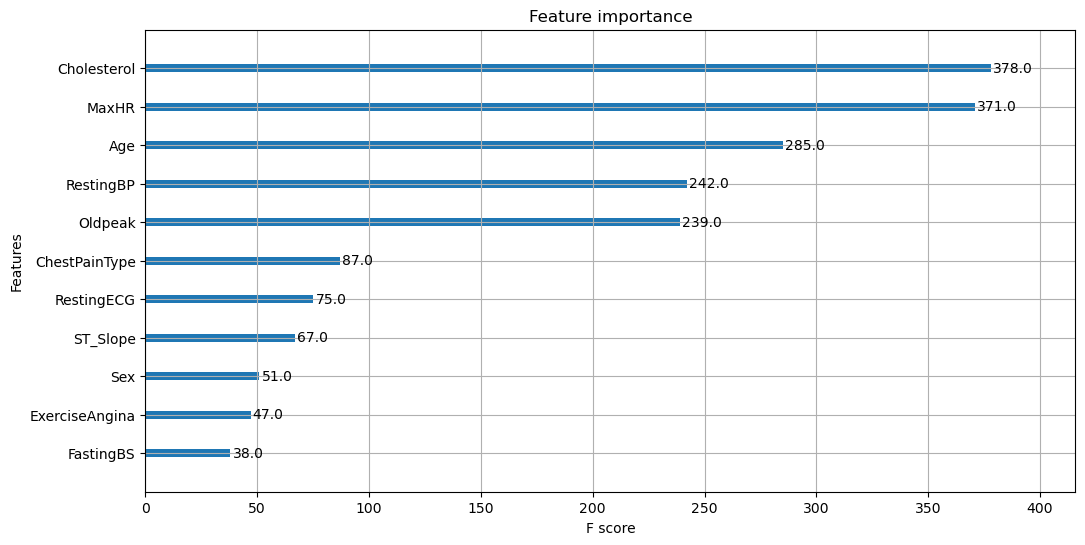

In [31]:
# fit model on training data
from xgboost import plot_importance
model = XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
plt.show()

## We see Cholesterol and MaxHr as the two most important features

In [30]:
# compare different numbers of features selected using anova f-test
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# define models to test
def get_models():
  models, names = list(), list()
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # XGB
  models.append(XGBClassifier())
  names.append('XGB')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # KNN
  models.append(KNeighborsClassifier())
  names.append('KNN')
  # SVC
  models.append(SVC())
  names.append('SVC')
  # LR
  models.append(LogisticRegression())
  names.append('LR')
  # GNB
  models.append(GaussianNB())
  names.append('GNB')
  return models, names

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
# define dataset
models,names = [], []
models, names = get_models()
num_features = [i+1 for i in range(X.shape[1])][len(X.columns)//2:]
# Model Performance:
model_performance = []
for k in num_features:
  # create pipeline
  fs = SelectKBest(score_func=f_classif, k=k)
  for i in range(len(models)):
    model = models[i]
    # Wrap the model in a pipeline with StandardScaler
    pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),("power_tranformer", PowerTransformer()), ('anova',fs), ('model', model)])
    # Evaluate the model
    scores = evaluate_model(X, y, pipeline)
    # summarize and store
    print('>%s %.3f (%.3f) k=%d' % (names[i], np.mean(scores), np.std(scores), k))
    print("---------------------------------------------------------------")
    model_performance.append({
            "Model": model,
            "mean": np.mean(scores),
            "std":np.std(scores),
            "column":k
        })
model_performance = pd.DataFrame(model_performance)
model_performance.sort_values(by="mean", ascending=False)

>RFC 0.852 (0.034) k=6
---------------------------------------------------------------
>XGB 0.849 (0.033) k=6
---------------------------------------------------------------
>GBC 0.864 (0.044) k=6
---------------------------------------------------------------
>KNN 0.855 (0.052) k=6
---------------------------------------------------------------
>SVC 0.883 (0.041) k=6
---------------------------------------------------------------
>LR 0.857 (0.040) k=6
---------------------------------------------------------------
>GNB 0.859 (0.039) k=6
---------------------------------------------------------------
>RFC 0.866 (0.046) k=7
---------------------------------------------------------------
>XGB 0.849 (0.044) k=7
---------------------------------------------------------------
>GBC 0.873 (0.043) k=7
---------------------------------------------------------------
>KNN 0.854 (0.047) k=7
---------------------------------------------------------------
>SVC 0.885 (0.039) k=7
---------------------

,Model,mean,std,column
32,SVC(),0.906968,0.038487,10
39,SVC(),0.906928,0.036220,11
25,SVC(),0.901808,0.035170,9
35,RandomForestClassifier(),0.901275,0.034778,11
28,RandomForestClassifier(),0.899161,0.036871,10
18,SVC(),0.898197,0.035031,8
23,GradientBoostingClassifier(),0.894505,0.038872,9
30,GradientBoostingClassifier(),0.893767,0.044520,10
37,GradientBoostingClassifier(),0.891655,0.038757,11
36,"XGBClassifier(base_score=None, booster=None, c...",0.890384,0.033021,11


In [42]:
# compare different numbers of features selected using anova f-test
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# define models to test
def get_models():
  models, names = list(), list()
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # XGB
  models.append(XGBClassifier())
  names.append('XGB')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # KNN
  models.append(KNeighborsClassifier())
  names.append('KNN')
  # SVC
  models.append(SVC())
  names.append('SVC')
  # LR
  models.append(LogisticRegression())
  names.append('LR')
  # GNB
  models.append(GaussianNB())
  names.append('GNB')
  return models, names

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
# define dataset
models,names = [], []
models, names = get_models()
num_features = [i+1 for i in range(X.shape[1])][len(X.columns)//2:]
# Model Performance:
model_performance = []
for k in num_features:
  # create pipeline
  fs = SelectKBest(score_func=mutual_info_classif, k=k)
  for i in range(len(models)):
    model = models[i]
    # Wrap the model in a pipeline with StandardScaler
    pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),("power_tranformer", PowerTransformer()), ('mutal_info',fs), ('model', model)])
    # Evaluate the model
    scores = evaluate_model(X, y, pipeline)
    # summarize and store
    print('>%s %.3f (%.3f) k=%d' % (names[i], np.mean(scores), np.std(scores), k))
    print("---------------------------------------------------------------")
    model_performance.append({
            "Model": model,
            "mean": np.mean(scores),
            "std":np.std(scores),
            "column":k
        })
model_performance = pd.DataFrame(model_performance)
model_performance.sort_values(by="mean", ascending=False)

>RFC 0.870 (0.036) k=6
---------------------------------------------------------------
>XGB 0.860 (0.046) k=6
---------------------------------------------------------------
>GBC 0.883 (0.033) k=6
---------------------------------------------------------------
>KNN 0.870 (0.037) k=6
---------------------------------------------------------------
>SVC 0.894 (0.030) k=6
---------------------------------------------------------------
>LR 0.862 (0.041) k=6
---------------------------------------------------------------
>GNB 0.869 (0.029) k=6
---------------------------------------------------------------
>RFC 0.875 (0.040) k=7
---------------------------------------------------------------
>XGB 0.859 (0.040) k=7
---------------------------------------------------------------
>GBC 0.886 (0.041) k=7
---------------------------------------------------------------
>KNN 0.864 (0.040) k=7
---------------------------------------------------------------
>SVC 0.899 (0.031) k=7
---------------------

,Model,mean,std,column
39,SVC(),0.906928,0.036220,11
32,SVC(),0.905212,0.038079,10
25,SVC(),0.904144,0.034260,9
11,SVC(),0.898569,0.030723,7
18,SVC(),0.898358,0.032203,8
35,RandomForestClassifier(),0.896810,0.037702,11
28,RandomForestClassifier(),0.894897,0.034469,10
4,SVC(),0.893529,0.030019,6
30,GradientBoostingClassifier(),0.893075,0.044498,10
14,RandomForestClassifier(),0.892037,0.031545,8


# Feature Importance Analysis - ANOVA provided better scores as opposed to mutal information. It seems like 8-10 columns could be suitable for further testing but lets test without reducing the dimensionality vs with using the dimensionality

In [ ]:
# compare different numbers of features selected using anova f-test
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# define models to test
def get_models():
  models, names = list(), list()
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # XGB
  models.append(XGBClassifier())
  names.append('XGB')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # KNN
  models.append(KNeighborsClassifier())
  names.append('KNN')
  # SVC
  models.append(SVC())
  names.append('SVC')
  # LR
  models.append(LogisticRegression())
  names.append('LR')
  # GNB
  models.append(GaussianNB())
  names.append('GNB')
  return models, names

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
# define dataset
models,names = [], []
models, names = get_models()
num_features = [i+1 for i in range(X.shape[1])][len(X.columns)//2:]
# Model Performance:
model_performance = []
for k in num_features:
  # create pipeline
  fs = SelectKBest(score_func=f_classif, k=k)
  for i in range(len(models)):
    model = models[i]
    # Wrap the model in a pipeline with StandardScaler
    pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),("power_tranformer", PowerTransformer()), ('anova',fs), ('model', model)])
    # Evaluate the model
    scores = evaluate_model(X, y, pipeline)
    # summarize and store
    print('>%s %.3f (%.3f) k=%d' % (names[i], np.mean(scores), np.std(scores), k))
    print("---------------------------------------------------------------")
    model_performance.append({
            "Model": model,
            "mean": np.mean(scores),
            "std":np.std(scores),
            "column":k
        })
model_performance = pd.DataFrame(model_performance)
model_performance.sort_values(by="mean", ascending=False)

### Without Reducing Dimesionality

Model: RFC, Accuracy: 0.853, F2 Score: 0.873


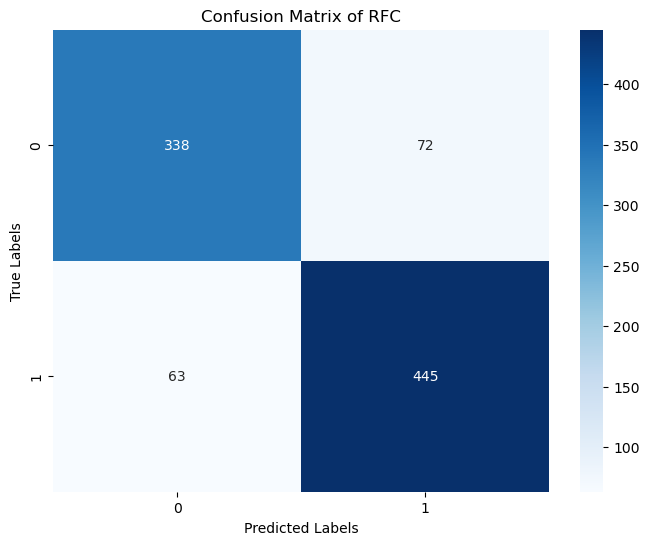

Model: GBC, Accuracy: 0.847, F2 Score: 0.861


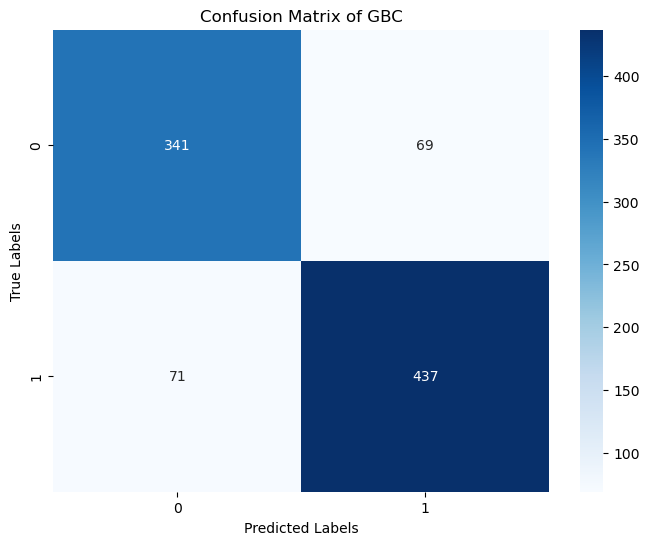

Model: XGB, Accuracy: 0.850, F2 Score: 0.868


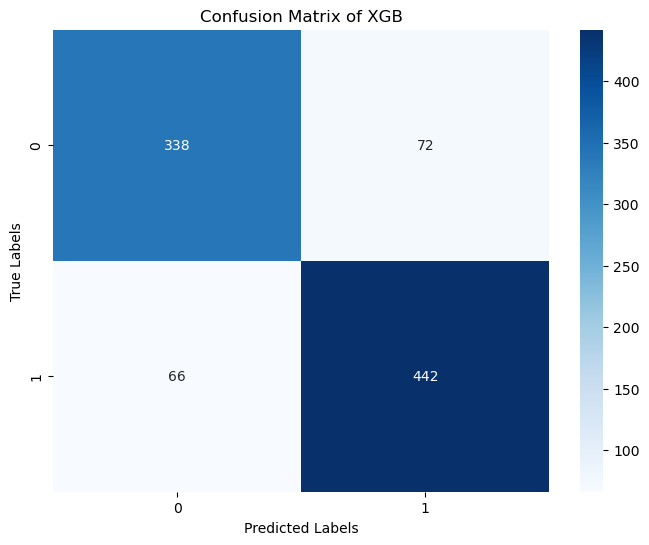

Model: SVC, Accuracy: 0.870, F2 Score: 0.897


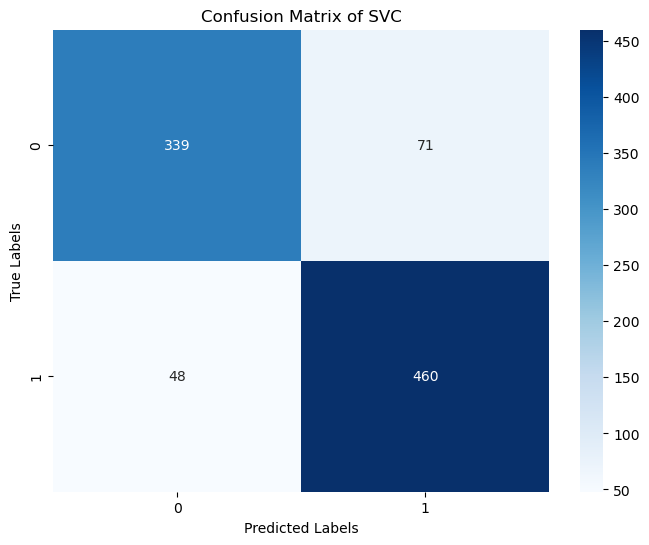

Model: GNB, Accuracy: 0.844, F2 Score: 0.869


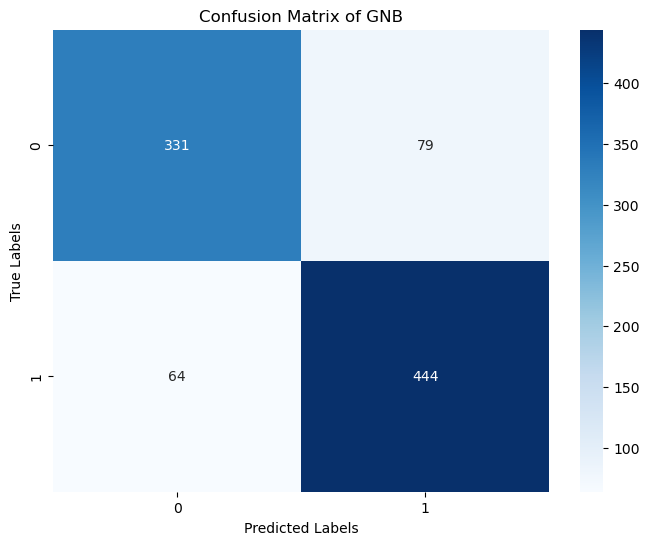

  Model  Accuracy  F2 Score
0   RFC  0.852941  0.872891
1   GBC  0.847495  0.860914
2   XGB  0.849673  0.868028
3   SVC  0.870370  0.897386
4   GNB  0.844227  0.868885


In [35]:
from sklearn.calibration import cross_val_predict

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# define models to test
def get_models():
  models, names = list(), list()
  
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # XGB
  models.append(XGBClassifier())
  names.append('XGB')
  # SVC
  models.append(SVC())
  names.append('SVC')
  # GNB
  models.append(GaussianNB())
  names.append('GNB')
  return models, names

models, names = [],[]
models, names = get_models()
model_performance = []
for i in range(len(models)):
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('power_transformer', PowerTransformer()), 
        ('model', models[i])
    ])
    
    y_pred = cross_val_predict(pipeline, X, y, cv=10) 

    # Compute the desired metrics
    accuracy = accuracy_score(y, y_pred)
    f2 = f2_measure(y, y_pred)

    model_performance.append({
        "Model": names[i],
        "Accuracy": accuracy,
        "F2 Score": f2
    })

    print(f"Model: {names[i]}, Accuracy: {accuracy:.3f}, F2 Score: {f2:.3f}")
    
    # Generate the confusion matrix
    conf_mat = confusion_matrix(y, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix of {names[i]}')
    plt.show()

# Convert the model_performance to a DataFrame for easier analysis
performance_df = pd.DataFrame(model_performance)
print(performance_df)

### Let us try with applying the Kbest columns

Model: RFC, Accuracy: 0.854, F2 Score: 0.875


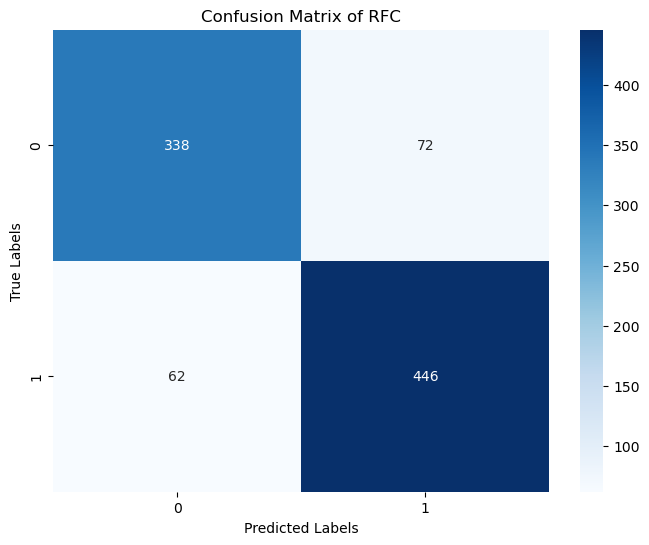

Model: GBC, Accuracy: 0.851, F2 Score: 0.867


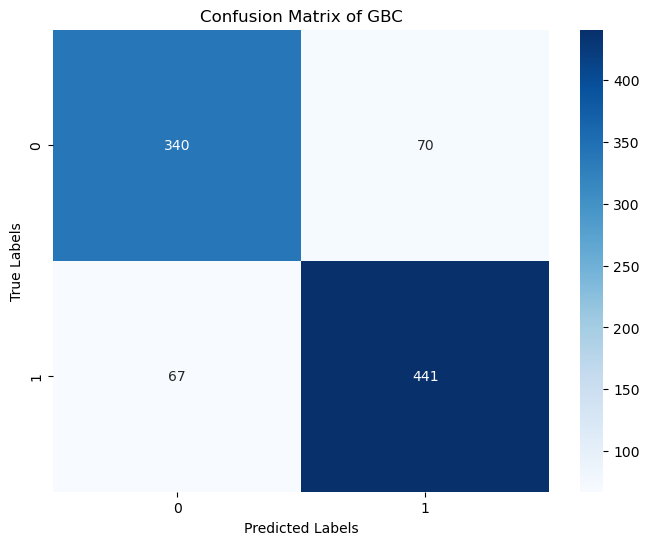

Model: XGB, Accuracy: 0.841, F2 Score: 0.858


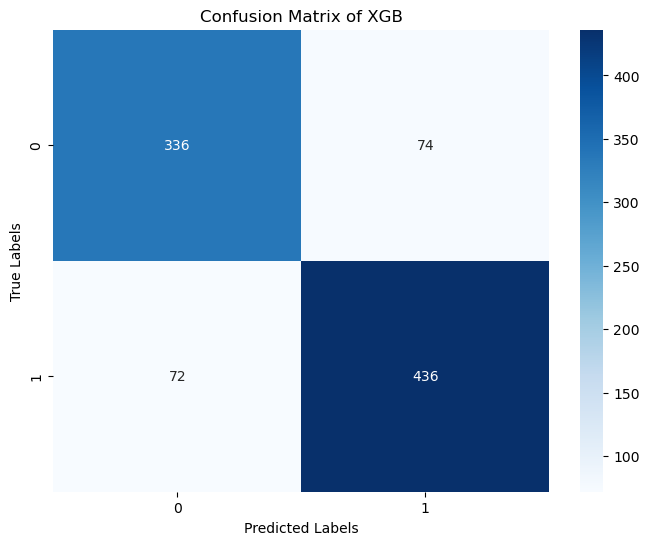

Model: SVC, Accuracy: 0.869, F2 Score: 0.896


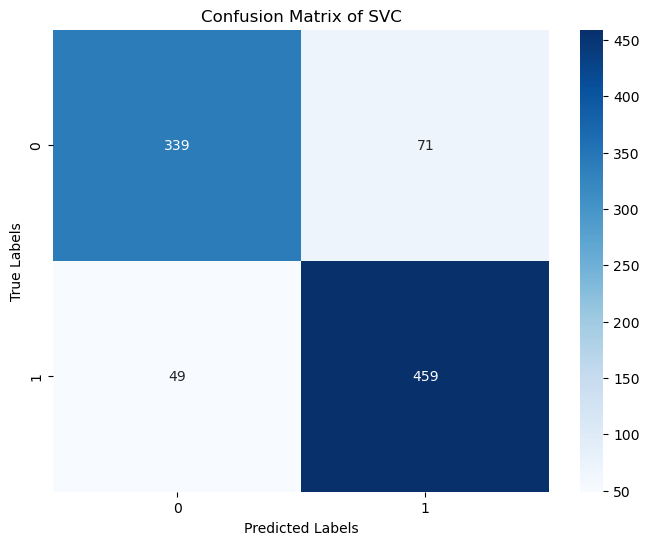

Model: GNB, Accuracy: 0.847, F2 Score: 0.872


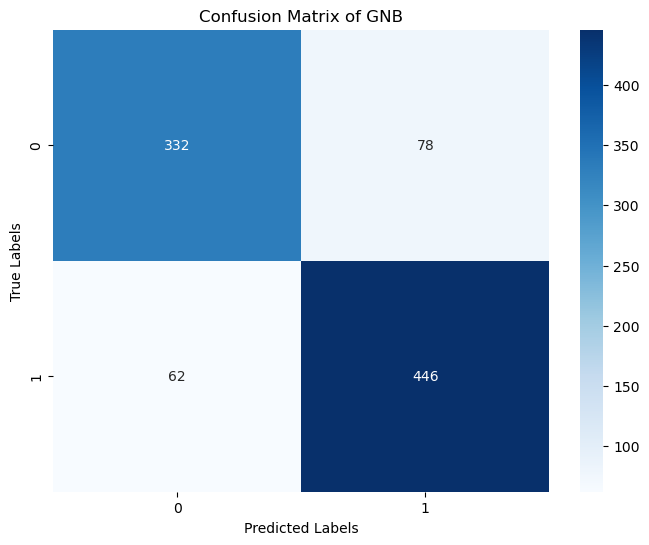

  Model  Accuracy  F2 Score
0   RFC  0.854031  0.874510
1   GBC  0.850763  0.867086
2   XGB  0.840959  0.857592
3   SVC  0.869281  0.895785
4   GNB  0.847495  0.872457


In [36]:
from sklearn.calibration import cross_val_predict

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# define models to test
def get_models():
  models, names = list(), list()
  
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # XGB
  models.append(XGBClassifier())
  names.append('XGB')
  # SVC
  models.append(SVC())
  names.append('SVC')
  # GNB
  models.append(GaussianNB())
  names.append('GNB')
  return models, names

models, names = [],[]
models, names = get_models()
model_performance = []
for i in range(len(models)):
    fs = SelectKBest(score_func=f_classif, k=10)
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('power_transformer', PowerTransformer()), 
        ("anova", fs),
        ('model', models[i])
    ])
    
    y_pred = cross_val_predict(pipeline, X, y, cv=10) 

    # Compute the desired metrics
    accuracy = accuracy_score(y, y_pred)
    f2 = f2_measure(y, y_pred)

    model_performance.append({
        "Model": names[i],
        "Accuracy": accuracy,
        "F2 Score": f2
    })

    print(f"Model: {names[i]}, Accuracy: {accuracy:.3f}, F2 Score: {f2:.3f}")
    
    # Generate the confusion matrix
    conf_mat = confusion_matrix(y, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix of {names[i]}')
    plt.show()

# Convert the model_performance to a DataFrame for easier analysis
performance_df = pd.DataFrame(model_performance)
print(performance_df)

# Feature Selection reduced scores by a 0.5 percent in return reducing out feature space by 1. This trade off may not be worth it or we may have to try different methods like PCA.

# Hyper Parameter Tuning 

Model: RFC, Accuracy: 0.958, F2 Score: 0.971, Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}


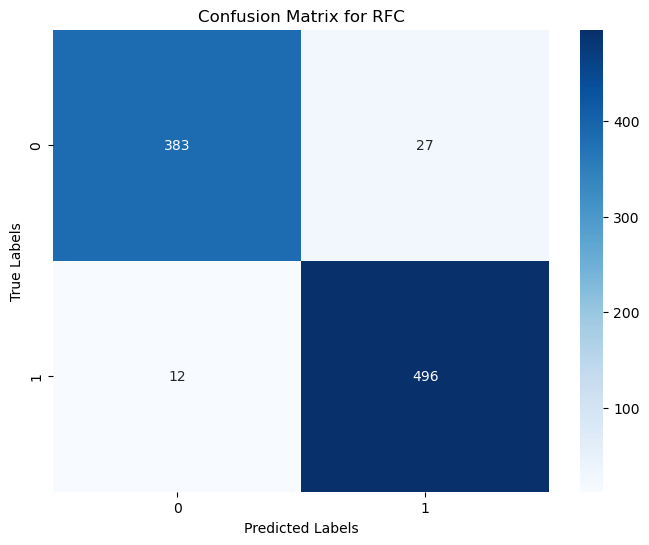

Model: GBC, Accuracy: 0.875, F2 Score: 0.920, Best Params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}


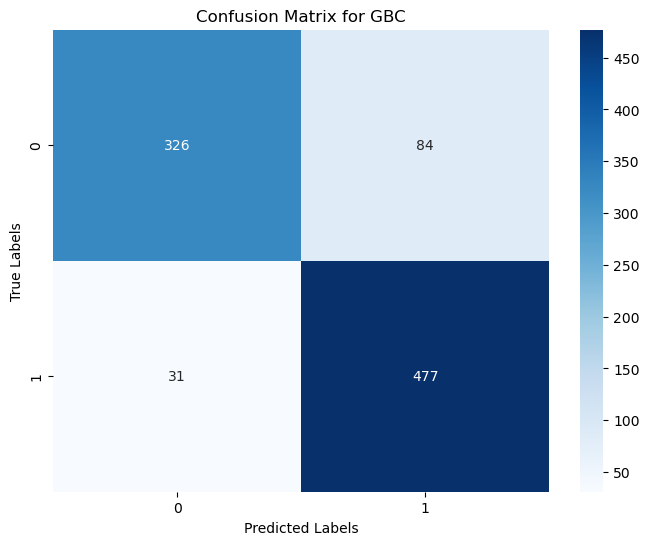

Model: XGB, Accuracy: 0.907, F2 Score: 0.943, Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 50, 'model__subsample': 1}


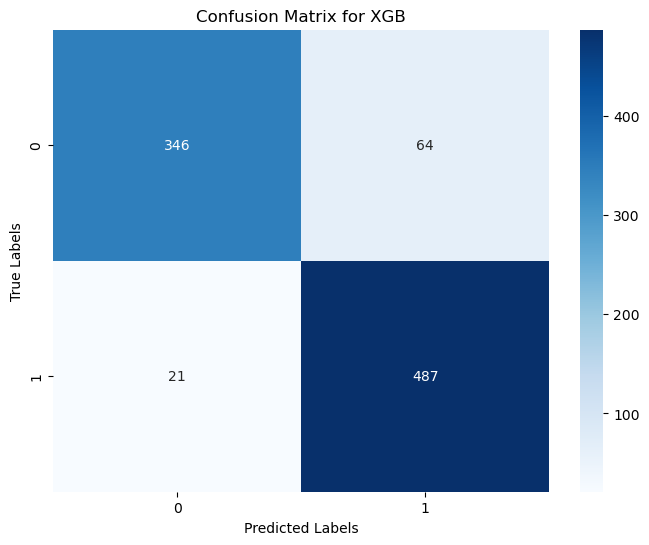

Model: SVC, Accuracy: 0.874, F2 Score: 0.912, Best Params: {'model__C': 0.1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}


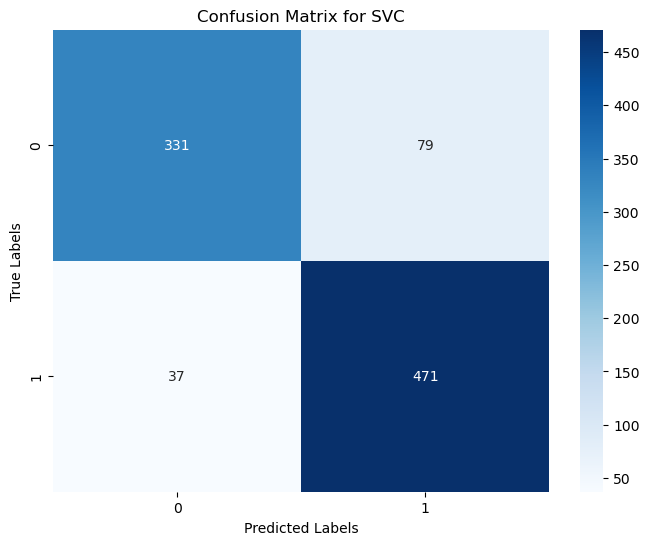

In [38]:
from sklearn.model_selection import GridSearchCV

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# define models to test
def get_models():
  models, names = list(), list()
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # XGBC
  models.append(XGBClassifier())
  names.append("XGB")
  # SVC
  models.append(SVC())
  names.append('SVC')
  return models, names

models, names = [], []
models, names = get_models()
model_performance = []

params = [
    {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    {
        'model__learning_rate': [0.1, 0.01],
        'model__max_depth': [3, 5, 7],
        'model__min_child_weight': [1, 3],
        'model__subsample': [0.8, 1],
        'model__colsample_bytree': [0.8, 1],
        'model__n_estimators': [50, 100]
    },
    {
        'model__C': [0.1, 1, 10],
        'model__gamma': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    },
]

for i in range(len(models)):
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ("power_transformer", PowerTransformer()),
        ("anova", SelectKBest(score_func=f_classif, k=10)),
        ('model', models[i])
    ])
    
    f2_scorer = make_scorer(f2_measure)
    # Set up the grid search
    grid_search = GridSearchCV(estimator=pipeline, param_grid=params[i], cv=10, scoring=f2_scorer, n_jobs=-1)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X)
    
    # Compute the desired metrics using the best model found by grid search
    accuracy = accuracy_score(y, y_pred)
    f2 = f2_measure(y, y_pred)

    model_performance.append({
        "Model": names[i],
        "Accuracy": accuracy,
        "F2 Score": f2,
        "Best Params": grid_search.best_params_
    })

    print(f"Model: {names[i]}, Accuracy: {accuracy:.3f}, F2 Score: {f2:.3f}, Best Params: {grid_search.best_params_}")
    # Generate the confusion matrix
    conf_mat = confusion_matrix(y, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {names[i]}')
    plt.show()

# Conclusion

## I have received anywhere from 91%-97% for a F2-score for hyper parameter tuning. Further evidence, to never stop tuning your model. I had a great time with this dataset, thank you to the community for putting it together.